**Project 1 - Advanced Corporate Finance**

Humphrey Hui - hh32346

Peyton Gibbs - peg694

Jack Feen - jaf5542

### Part I. Data Preparation
1. Connect to WRDS via Python
2. Query CRSP Monthly Stock File (MSF) and join with name history tables to filter:
   * U.S. common shares only: shrcd ! {10,11}
   * Major exchanges only: exchcd ! {1,2,3}
3. Clean the data:
   * Standardize price signs (absolute value).
   * Convert shares outstanding from thousands.
   * Compute market capitalization for each security and month.
4. Incorporate delisting returns (msedelist) to compute effective monthly returns

In [89]:
import pandas as pd
import numpy as np
import datetime as dt
import wrds
import matplotlib.pyplot as plt
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
from scipy import stats
from typing import List
import seaborn as sns

In [90]:
import wrds
db = wrds.Connection()

Loading library list...
Done


In [91]:
# Query crsp msf and filter
crsp_m = db.raw_sql("""
                      select a.permno, a.permco, a.date, b.shrcd, b.exchcd,
                      a.ret, a.retx, a.shrout, a.prc, b.ticker, b.comnam, b.hsiccd
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/2015' and '12/31/2024'
                      and b.exchcd between 1 and 3
                      and b.shrcd in (10, 11)
                      """, date_cols=['date']) 

# Clean identifiers and align dates to month-end
crsp_m[['permco','permno','shrcd','exchcd']] = crsp_m[['permco','permno','shrcd','exchcd']].astype(int)
crsp_m['jdate'] = crsp_m['date'] + MonthEnd(0)

# Standardize prices and calculate market equity
crsp_m['prc'] = crsp_m['prc'].abs()
crsp_m['shrout'] = crsp_m['shrout'] * 1000
crsp_m['me'] = crsp_m['prc'] * crsp_m['shrout']

# Collapse to firm-level market equity by month
crsp_summe = crsp_m.groupby(['jdate','permco'])['me'].sum().reset_index()
crsp_maxme = crsp_m.groupby(['jdate','permco'])['me'].max().reset_index()
crsp1 = pd.merge(crsp_m, crsp_maxme, how='inner', on=['jdate','permco','me'])
crsp1 = crsp1.drop(['me'], axis=1)
crsp2 = pd.merge(crsp1, crsp_summe, how='inner', on=['jdate','permco'])

# Finalize monthly panel with year and month tags
crsp2 = crsp2.sort_values(by=['permno','jdate']).drop_duplicates()
crsp2['year'] = crsp2['jdate'].dt.year
crsp2['month'] = crsp2['jdate'].dt.month

market_capitalization = crsp2[['permno','date','jdate','me','year','month']]
market_capitalization


,permno,date,jdate,me,year,month
83,10001,2015-01-30,2015-01-31,102258000.0,2015,1
84,10001,2015-02-27,2015-02-28,105928800.0,2015,2
85,10001,2015-03-31,2015-03-31,104101920.0,2015,3
86,10001,2015-04-30,2015-04-30,105251640.0,2015,4
87,10001,2015-05-29,2015-05-31,104880000.0,2015,5
...,...,...,...,...,...,...
453287,93436,2024-08-30,2024-08-31,684004370400.0,2024,8
453288,93436,2024-09-30,2024-09-30,839047410000.0,2024,9
453289,93436,2024-10-31,2024-10-31,802033523100.599976,2024,10
453290,93436,2024-11-29,2024-11-30,1107984309600.0,2024,11


In [92]:
# Obtain delisted returns
dlret = db.raw_sql("""
                     select permno, dlret, dlstdt 
                     from crsp.msedelist
                     """, date_cols=['dlstdt'])

dlret.permno=dlret.permno.astype(int)

In [93]:
# Standardize and clean delisted and final CRSP data
dlret['jdate'] = dlret['dlstdt'] + MonthEnd(0)  # Align delisting dates to month-end

crsp_final = pd.merge(crsp2, dlret[['permno', 'jdate', 'dlret']], 
                      on=['permno', 'jdate'], how='left')

crsp_final['dlret'] = crsp_final['dlret'].fillna(0)
crsp_final['ret_eff'] = (1 + crsp_final['ret'].fillna(0)) * (1 + crsp_final['dlret']) - 1
crsp_final_clean = crsp_final[['permno', 'jdate', 'prc', 'shrout', 'ret', 'dlret', 'ret_eff', 'me', 'hsiccd']].copy()
crsp_final_clean = crsp_final_clean.rename(columns={'jdate': 'date', 'me': 'mktcap'})
crsp_final_clean = crsp_final_clean.dropna(subset=['ret_eff', 'mktcap'])
crsp_final_clean = crsp_final_clean[crsp_final_clean['mktcap'] > 0]

# Code below commented, used to obtain HHI graph without Berkshire Hathaway
# crsp_final_clean = crsp_final_clean[crsp_final_clean['permno'] != 17778]

### Part II. Index Construction
1. Implement monthly reconstitution and rebalancing:
   * Use t−1 information only to avoid look-ahead bias.
   * Select the Top-N securities by market cap at each month-end.
   * Carry forward index values in months with incomplete data.
2. Build three indexes:
   * Equal-Weighted (EW)
   * Value-Weighted (VW)
   * Price-Weighted (PW)
3. Initialize all indexes with base level = 100

In [95]:
# Build index
def build_topn_indexes(panel: pd.DataFrame, top_n: int) -> pd.DataFrame:
    """Construct Equal-, Value-, and Price-Weighted index levels (base=100).

    Methodology reminder:
    At month t, choose constituents and weights from t-1 information.
    Grow index from t-1 to t using ret_eff (includes delistings).

    Returns a DataFrame with three columns (EW, VW, PW) indexed by month t.
    """
    # Organize by month for quick lookup
    panel = panel.sort_values(['date', 'permno'])
    months = sorted(panel['date'].unique())
    by_month = {d: g for d, g in panel.groupby('date')}
    ew_level = [100.0]
    vw_level = [100.0]
    pw_level = [100.0]
    hhi_ew_list = [] # add lists for HHI analysis
    hhi_vw_list = []
    hhi_pw_list = []

    # Loop from the 2nd available month; we need t-1 and t
    for i in range(1, len(months)):
        
        t_1, t = months[i-1], months[i]
        g_t1 = by_month[t_1].dropna(subset=['mktcap', 'prc'])
        g_t = by_month[t]
        if g_t1.empty or g_t.empty:
            # If either month lacks data, carry forward
            ew_level.append(ew_level[-1])
            vw_level.append(vw_level[-1])
            pw_level.append(pw_level[-1])
            continue
        # Top-N by market cap at t-1 (investable & no look-ahead)
        chosen = g_t1.sort_values('mktcap', ascending=False).head(top_n).set_index('permno')
        # Ensure we have returns at t for the chosen PERMNOs
        g_t = g_t.set_index('permno')
        common = chosen.index.intersection(g_t.index)
        if len(common) == 0:
            ew_level.append(ew_level[-1])
            vw_level.append(vw_level[-1])
            pw_level.append(pw_level[-1])
            continue
        
        r_t = g_t.loc[common, 'ret_eff'].astype(float)
        sector = g_t.loc[common,'hsiccd']
        # Equal-Weighted: average of gross returns over available names
        mask_ew = r_t.notna()
        sector_ew = sector.loc[mask_ew]
        r_t_ew = r_t.loc[mask_ew]
        p_ew = (sector_ew.value_counts()/len(sector_ew))
        hhi_ew = (p_ew**2).sum()
        hhi_ew_list.append(hhi_ew)
        ew_gross = (1.0 + r_t_ew).mean() if not r_t_ew.empty else 1.0

        # Value-Weighted: weights from t-1 market cap
        w_vw = chosen.loc[common, 'mktcap'].astype(float)
        mask_vw = r_t.notna()
        w_vw = w_vw.loc[mask_vw]
        r_vw = r_t.loc[mask_vw]
        sector_vw = sector.loc[mask_vw]
        if w_vw.empty or w_vw.sum() <= 0:
            vw_gross = 1.0
        else:
            w_vw = w_vw / w_vw.sum()
            p_vw = w_vw.groupby(sector_vw).sum()
            hhi_vw = (p_vw**2).sum()
            hhi_vw_list.append(hhi_vw)
            vw_gross = ((1.0 + r_vw) * w_vw).sum()

        # Price-Weighted: weights from t-1 price (Dow-style approximation)
        w_pw = chosen.loc[common, 'prc'].astype(float)
        mask_pw = r_t.notna()
        w_pw = w_pw.loc[mask_pw]
        r_pw = r_t.loc[mask_pw]
        sector_pw = sector.loc[mask_pw]
        if w_pw.empty or w_pw.sum() <= 0:
            pw_gross = 1.0
        else:
            w_pw = w_pw / w_pw.sum()
            p_pw = w_pw.groupby(sector_pw).sum()
            hhi_pw = (p_pw**2).sum()
            hhi_pw_list.append(hhi_pw)
            pw_gross = ((1.0 + r_pw) * w_pw).sum()

        # Compound index levels
        ew_level.append(ew_level[-1] * float(ew_gross))
        vw_level.append(vw_level[-1] * float(vw_gross))
        pw_level.append(pw_level[-1] * float(pw_gross))

    # Convert to tidy Series/DataFrame indexed by month t (growth from t-1 to t)
    idx_months = pd.to_datetime(months[1:])
    ew = pd.Series(ew_level[1:], index=idx_months, name='Equal-Weighted')
    vw = pd.Series(vw_level[1:], index=idx_months, name='Value-Weighted')
    pw = pd.Series(pw_level[1:], index=idx_months, name='Price-Weighted')
    hhi_ew = pd.Series(hhi_ew_list, index=idx_months, name='HHI Equal-Weighted') # Create HHI dataframes
    hhi_vw = pd.Series(hhi_vw_list, index=idx_months, name='HHI Value-Weighted')
    hhi_pw = pd.Series(hhi_pw_list, index=idx_months, name='HHI Price-Weighted')
    return pd.concat([ew, vw, pw, hhi_ew, hhi_vw, hhi_pw], axis=1)

# Initialize all indexes with base level 100
indexes = build_topn_indexes(crsp_final_clean, 100)
custom_indexes = indexes[['Equal-Weighted', 'Value-Weighted', 'Price-Weighted']]
hhi_indexes = indexes[['HHI Equal-Weighted', 'HHI Value-Weighted', 'HHI Price-Weighted']]

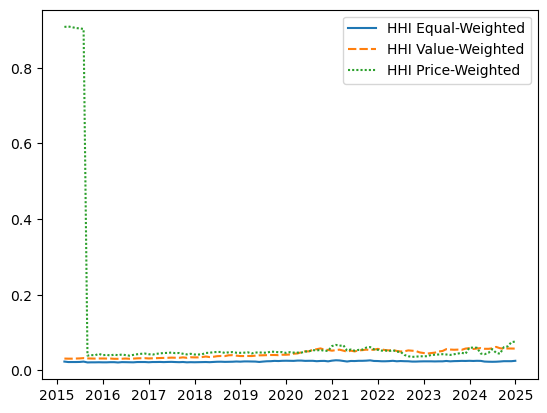

In [96]:
# Check HHI of the three indices
sns.lineplot(data = hhi_indexes);

### Part III. Benchmarking & Analytics
1. Retrieve benchmark ETF series (SPY, IWM, QQQ) from CRSP.
2. Compute log returns for custom indexes and ETFs.
3. Generate:
    * Time-series plots of index levels (custom vs. ETFs).
    * Heatmap correlation matrix of monthly log returns.  
4. Interpret:
    * Co-movement of custom indexes with ETFs.
    * Effects of weighting schemes on return/volatility.
    * Bias mitigation (look-ahead, survivorship)

In [98]:
def get_etf_index_by_ticker(db: wrds.Connection, ticker: str, start: str, end: str, label: str) -> pd.Series:
    """
    Build a 100-based index level for an ETF by compounding monthly returns,
    using a ticker instead of a permno. Automatically selects the permno
    active during the start date.
    """
    # Step 1: Find the permno for this ticker active at the start date
    names_query = f"""
        SELECT permno, namedt, nameendt, ticker, hsiccd
        FROM crsp.msenames
        WHERE ticker = '{ticker}'
    """
    names = db.raw_sql(names_query)
    # Convert dates and handle CRSP high date placeholder
    names['namedt'] = pd.to_datetime(names['namedt'])
    names['nameendt'] = pd.to_datetime(names['nameendt'].replace('E99991231', '2099-12-31'))
    
    # Select permno valid at the start date
    valid = names[(names['namedt'] <= start) & (names['nameendt'] >= start)]
    print(valid)
    if valid.empty:
        raise ValueError(f"No active permno found for ticker {ticker} at {start}")
    
    permno = valid.iloc[0]['permno']

    # Step 2: Pull monthly returns from CRSP for the selected permno
    q = f"""
        SELECT date, ret
        FROM crsp.msf
        WHERE permno = {permno}
          AND date BETWEEN '{start}' AND '{end}'
        ORDER BY date;
    """
    d = db.raw_sql(q)
    d['date'] = pd.to_datetime(d['date'])
    d = d.sort_values('date')
    d['ret'] = pd.to_numeric(d['ret'], errors='coerce').fillna(0.0)

    # Step 3: Compute the compounded index starting at 100
    idx = (1.0 + d['ret']).cumprod() * 100.0
    idx.index = d['date']
    idx.name = label

    return idx

In [99]:
# ChatGPT generated

# Define tickers and date range
etf_tickers = ["SPY", "IWM", "QQQ"]
start_date = "2015-01-01"
end_date = "2025-01-01"

# Dictionary to store each ETF series
etf_series = {}

# Loop over tickers and pull index series
for ticker in etf_tickers:
    try:
        etf_series[ticker] = get_etf_index_by_ticker(
            db=db,
            ticker=ticker,
            start=start_date,
            end=end_date,
            label=f"{ticker} (ETF)"
        )
        print(f"Fetched {ticker} successfully. {len(etf_series[ticker])} rows.")
    except Exception as e:
        print(f"Error fetching {ticker}: {e}")

# Example: inspect the first few rows of SPY
print(etf_series["SPY"].head())

   permno     namedt   nameendt ticker  hsiccd
6   84398 2010-01-27 2017-12-25    SPY    6726
Fetched SPY successfully. 120 rows.
   permno     namedt   nameendt ticker  hsiccd
6   88222 2012-10-01 2016-02-01    IWM    6726
Fetched IWM successfully. 120 rows.
   permno     namedt   nameendt ticker  hsiccd
3   86755 2011-03-23 2018-06-03    QQQ    6726
Fetched QQQ successfully. 120 rows.
date
2015-01-30       97.0371
2015-02-27     102.49107
2015-03-31    100.885958
2015-04-30     101.87807
2015-05-29    103.187815
Name: SPY (ETF), dtype: Float64


In [100]:
# ChatGPT generated

# Step 1: Convert the ETF dictionary into a DataFrame
etf_df = pd.concat(etf_series.values(), axis=1)
etf_df.columns = [s.name for s in etf_series.values()]

# Step 2: Reindex ETF DataFrame to match the month-end dates of custom_indexes
etf_df = etf_df.reindex(custom_indexes.index, method='ffill')  # forward-fill to last known value

# Step 3: Combine with custom indexes
combined_df = pd.concat([custom_indexes, etf_df], axis=1)

# Step 4: Sort by date
combined_df = combined_df.sort_index()

combined_df

,Equal-Weighted,Value-Weighted,Price-Weighted,SPY (ETF),IWM (ETF),QQQ (ETF)
2015-02-28,105.548457,105.735133,102.665691,102.49107,102.474431,104.987945
2015-03-31,103.643146,103.399301,100.944639,100.885958,104.2912,102.516319
2015-04-30,104.696587,104.929854,99.169486,101.87807,101.616235,104.487093
2015-05-31,106.223227,106.293720,99.846258,103.187815,103.888679,106.836485
2015-06-30,104.740390,104.466427,95.387616,101.105897,104.702127,104.190252
...,...,...,...,...,...,...
2024-08-31,301.618957,378.067469,334.796886,324.346048,208.714668,497.618162
2024-09-30,307.353578,386.633630,338.997927,331.150504,210.196124,510.654265
2024-10-31,303.751148,384.184842,335.223641,328.195317,207.217645,506.239148
2024-11-30,320.050617,406.067287,354.521616,347.766916,230.160369,533.326993


In [102]:
# ChatGPT Generated

# Step 1: Create a copy of combined_df to avoid modifying the original
df = combined_df.copy()

# Step 2: Compute log returns relative to 100 for the first row
first_month = np.log(df.iloc[0] / 100)

# Step 3: Compute log returns for the rest of the months
rest = np.log(df / df.shift(1)).iloc[1:]

# Step 4: Concatenate the first row with the rest
log_returns_df = pd.concat([first_month.to_frame().T, rest])

# Step 5: Ensure the index matches the original DataFrame
log_returns_df.index = df.index

# Inspect the first few rows
log_returns_df.head()

,Equal-Weighted,Value-Weighted,Price-Weighted,SPY (ETF),IWM (ETF),QQQ (ETF)
2015-02-28,0.054,0.055767,0.026308,0.024605,0.024443,0.048675
2015-03-31,-0.018216,-0.022339,-0.016906,-0.015785,0.017574,-0.023824
2015-04-30,0.010113,0.014694,-0.017742,0.009786,-0.025984,0.019042
2015-05-31,0.014476,0.012914,0.006801,0.012774,0.022117,0.022236
2015-06-30,-0.014058,-0.01734,-0.045683,-0.020382,0.0078,-0.025081


<Axes: >

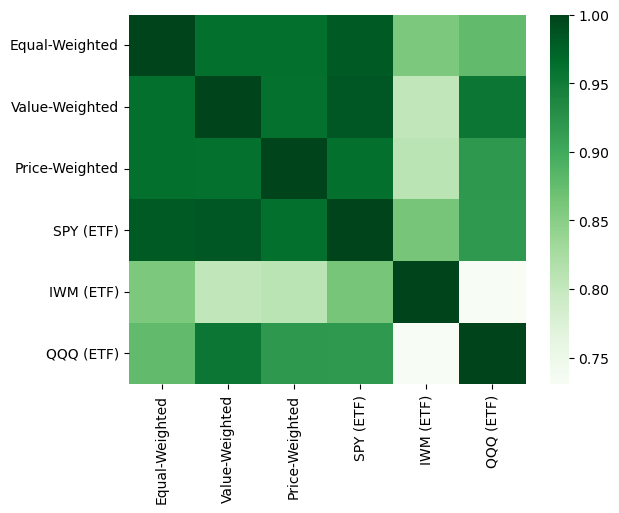

In [103]:
sns.heatmap(log_returns_df.corr(), cmap = 'Greens')

Text(0, 0.5, 'Price')

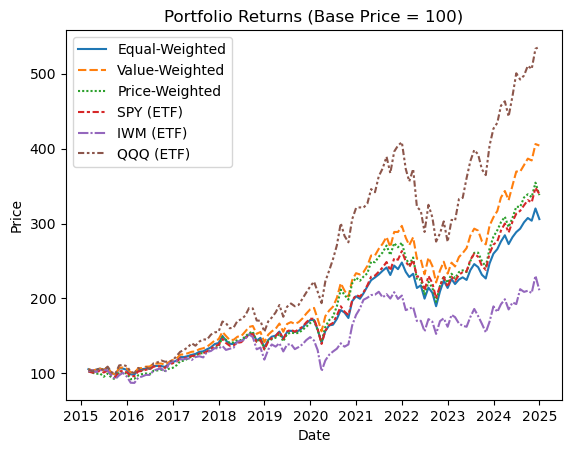

In [104]:
sns.lineplot(data = combined_df)
plt.title('Portfolio Returns (Base Price = 100)')
plt.xlabel('Date')
plt.ylabel('Price')

In [105]:
# ChatGPT Generated

def plot_rebased_returns(log_returns: pd.DataFrame, start_date: str, base: float = 100):
    """
    Plot rebased cumulative returns from log monthly returns.
    Keeps the original DataFrame intact.
    """
    # Ensure datetime index
    log_returns.index = pd.to_datetime(log_returns.index)

    # Restrict to dates >= start_date
    subset = log_returns.loc[log_returns.index >= start_date]

    if subset.empty:
        raise ValueError(f"No data available after {start_date}")

    # Convert log returns back to return factors
    factors = np.exp(subset)

    # Compute cumulative product of factors
    cum_index = factors.cumprod()

    # Rebase so the first row = base (e.g. 100)
    rebased = cum_index / cum_index.iloc[0] * base

    # Plot
    plt.figure(figsize=(10, 6))
    for col in rebased.columns:
        plt.plot(rebased.index, rebased[col], label=col)

    plt.title(f"Rebased Cumulative Returns (Start = {start_date}, Base = {base})")
    plt.xlabel("Date")
    plt.ylabel("Index Level")
    plt.legend()
    plt.grid(True)
    plt.show()

In [106]:
# ChatGPT Generated

def corr_matrix_from_logrets(df, start_date, plot=True, cmap="Blues", zoom_high=True):
    """
    Compute correlation matrix of monthly log returns after a given start date,
    with heatmap colors scaled for better visibility of differences.

    Args:
        df (pd.DataFrame): Monthly log returns, indexed by date, columns=ETFs
        start_date (str or pd.Timestamp): Starting date for correlation window
        plot (bool): If True, plots heatmap
        cmap (str): Colormap for heatmap
        zoom_high (bool): If True, exaggerate color differences for high correlations

    Returns:
        pd.DataFrame: Correlation matrix of ETFs
    """
    # Ensure datetime index
    df = df.copy()
    df.index = pd.to_datetime(df.index)

    # Slice from start_date
    df = df[df.index >= pd.to_datetime(start_date)]

    # Compute correlation matrix
    corr_mat = df.corr()

    if plot:
        # Determine color scaling
        if zoom_high:
            # Focus on upper range of correlations
            vmin = corr_mat.min().min()
            vmax = corr_mat.max().max()
            # If all correlations are high, zoom in between min and max
            if vmin > 0.7:
                vmin = max(0.7, vmin)  # clip lower end for better contrast
        else:
            vmin, vmax = corr_mat.min().min(), corr_mat.max().max()

        plt.figure(figsize=(8,6))
        sns.heatmap(corr_mat, annot=True, fmt=".2f", cmap=cmap, center=None,
                    vmin=vmin, vmax=vmax, linewidths=0.5, cbar_kws={"shrink":0.8})
        plt.title(f"Correlation Matrix of Log Returns (since {start_date})")
        plt.show()

    return corr_mat

Total Returns from 2015


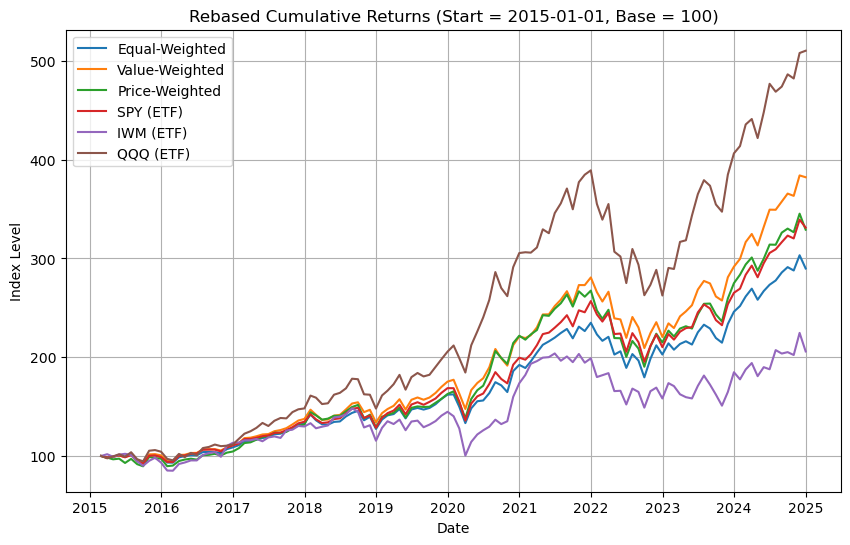

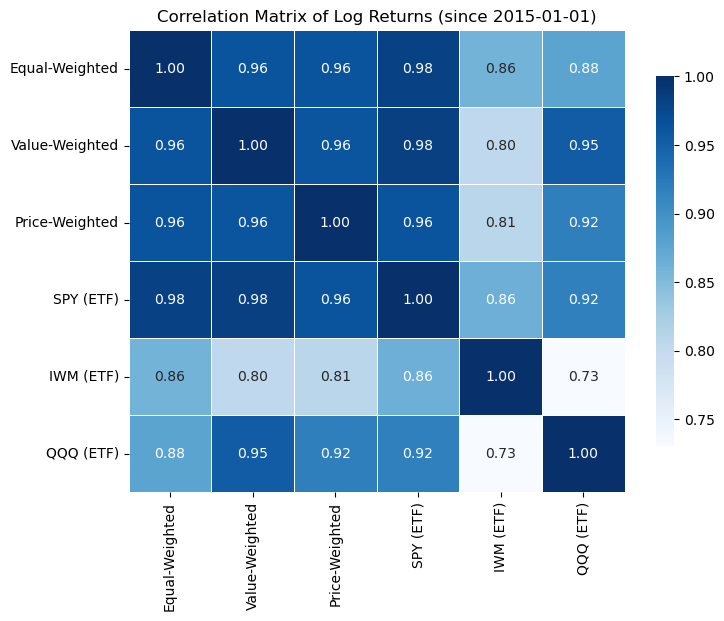

Returns Starting at Stock Boom


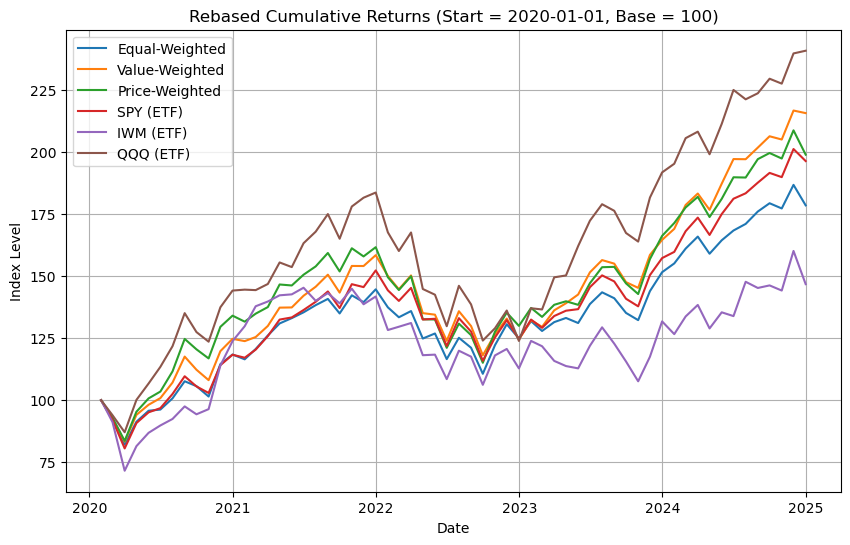

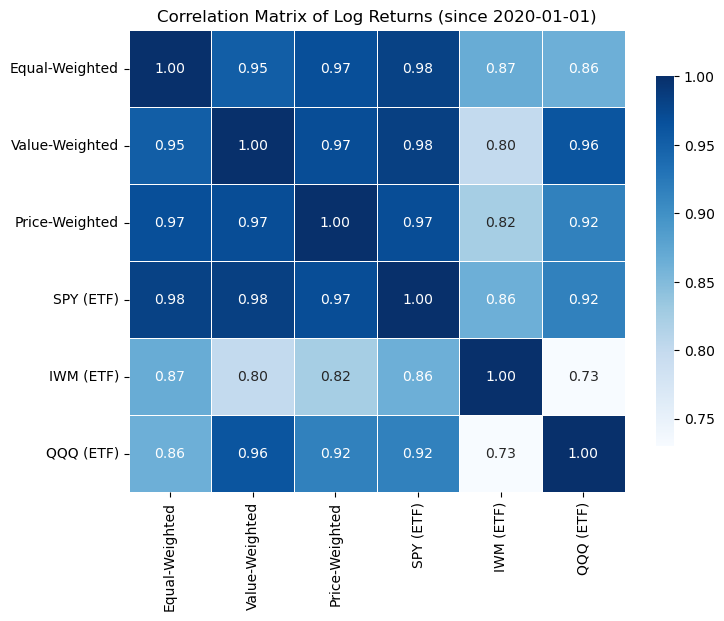

Returns Starting at Stock Crash


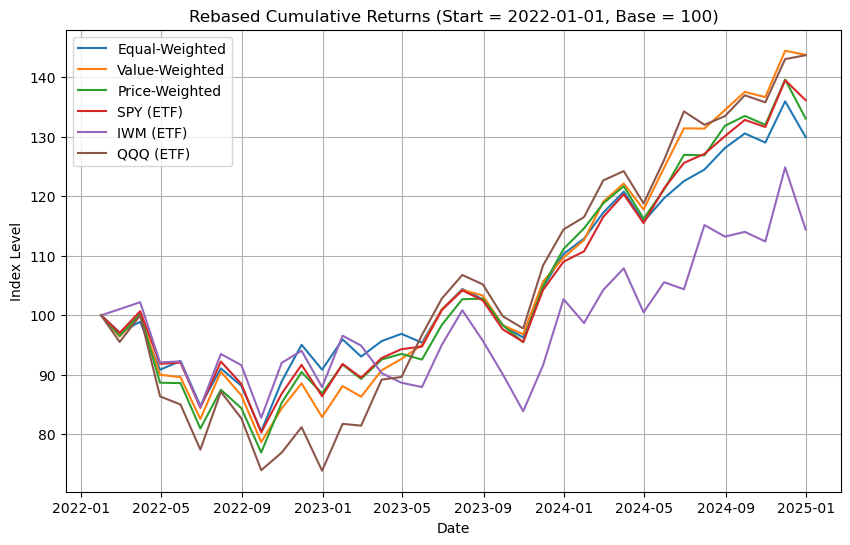

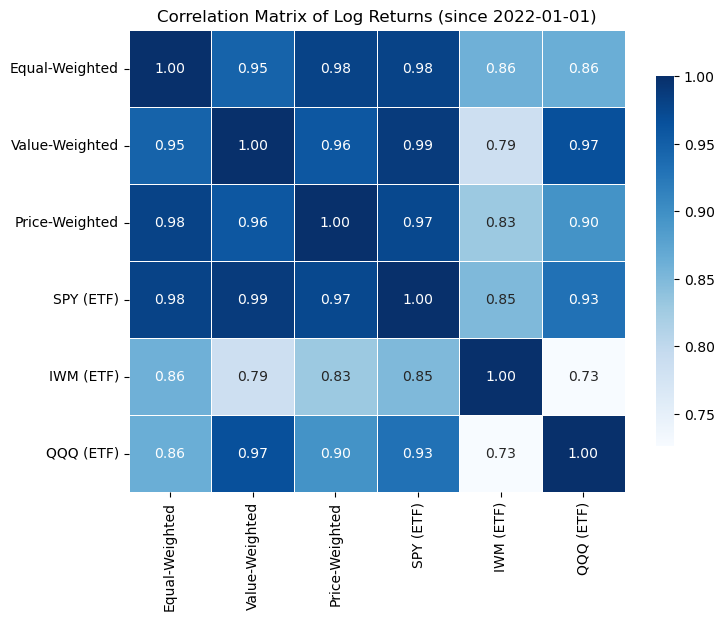

Returns with No Stock Crash


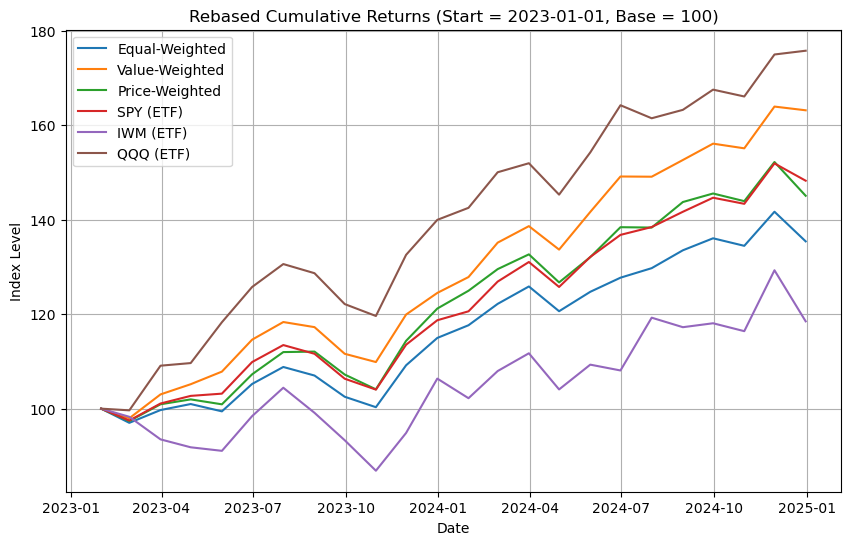

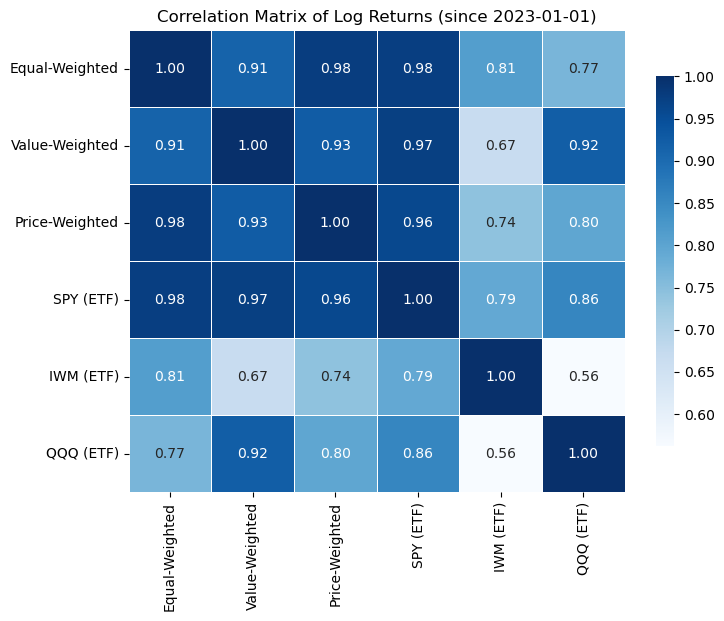

,Equal-Weighted,Value-Weighted,Price-Weighted,SPY (ETF),IWM (ETF),QQQ (ETF)
Equal-Weighted,1.000000,0.913943,0.976941,0.975709,0.812604,0.765737
Value-Weighted,0.913943,1.000000,0.925856,0.973446,0.668172,0.922068
Price-Weighted,0.976941,0.925856,1.000000,0.959323,0.741762,0.797769
SPY (ETF),0.975709,0.973446,0.959323,1.000000,0.792212,0.855889
IWM (ETF),0.812604,0.668172,0.741762,0.792212,1.000000,0.562144
QQQ (ETF),0.765737,0.922068,0.797769,0.855889,0.562144,1.000000


In [107]:
print('Total Returns from 2015')
plot_rebased_returns(log_returns_df, start_date = '2015-01-01', base = 100)
corr_matrix_from_logrets(log_returns_df, start_date = '2015-01-01')

print('Returns Starting at Stock Boom')
plot_rebased_returns(log_returns_df, start_date = '2020-01-01', base = 100)
corr_matrix_from_logrets(log_returns_df, start_date = '2020-01-01')


print("Returns Starting at Stock Crash")
plot_rebased_returns(log_returns_df, start_date = '2022-01-01', base = 100)
corr_matrix_from_logrets(log_returns_df, start_date = '2022-01-01')

print("Returns with No Stock Crash")
plot_rebased_returns(log_returns_df, start_date = '2023-01-01', base = 100)
corr_matrix_from_logrets(log_returns_df, start_date = '2023-01-01')